<a href="https://colab.research.google.com/github/yamkas/Intermediate-SQL-Syntax/blob/master/Intermediate_SQL_Syntax(for_student).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import sqlite3 as sql

In [ ]:
db = sql.connect('northwind.db')

In [ ]:
# query di bawah akan menampilkan tabel - tabel yang ada di database kita
query = """
SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';
"""

In [ ]:
# buat variabel cursor dari koneksi ke database kita
cursor = db.cursor()

In [ ]:
# menjalankan query dan menampilkan hasil
cursor.execute(query)
print(cursor.fetchall())

[('Suppliers',), ('Shippers',), ('Employees',), ('Customers',), ('Orders',), ('Categories',), ('Products',), ('OrderDetails',)]


In [ ]:
pd.read_sql("SELECT * FROM Employees LIMIT 2;", db)

,EmployeeID,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1966-12-08 00:00:00.000,2010-05-01 00:00:00.000,507 - 20th Ave. E.\nApt. 2A,Seattle,WA,98122,USA,(206) 555-9857,5467,b'\x15\x1c/\x00\x02\x00\x00\x00\r\x00\x0e\x00\...,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1970-02-19 00:00:00.000,2010-08-14 00:00:00.000,908 W. Capital Way,Tacoma,WA,98401,USA,(206) 555-9482,3457,b'\x15\x1c/\x00\x02\x00\x00\x00\r\x00\x0e\x00\...,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp


## 1. WINDOW FUNCTION

### 1.1 Group by vs Window Function

In [ ]:
# mari kita lihat tabel orders terlebih dahulu
query = """
SELECT * FROM orders;
"""
pd.read_sql(query, db)


,OrderID,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2014-07-04 08:00:00.000,2014-08-01 00:00:00.000,2014-07-16 00:00:00.000,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,None,51100,France
1,10249,TOMSP,6,2014-07-05 04:00:00.000,2014-08-16 00:00:00.000,2014-07-10 00:00:00.000,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,None,44087,Germany
2,10250,HANAR,4,2014-07-08 15:00:00.000,2014-08-05 00:00:00.000,2014-07-12 00:00:00.000,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,RJ,05454-876,Brazil
3,10251,VICTE,3,2014-07-08 14:00:00.000,2014-08-05 00:00:00.000,2014-07-15 00:00:00.000,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,None,69004,France
4,10252,SUPRD,4,2014-07-09 01:00:00.000,2014-08-06 00:00:00.000,2014-07-11 00:00:00.000,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,None,B-6000,Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,11073,PERIC,2,2016-05-05 12:00:00.000,2016-06-02 00:00:00.000,None,2,24.95,Pericles Comidas clásicas,Calle Dr. Jorge Cash 321,México D.F.,None,05033,Mexico
826,11074,SIMOB,7,2016-05-06 01:00:00.000,2016-06-03 00:00:00.000,None,2,18.44,Simons bistro,Vinbæltet 34,Kobenhavn,None,1734,Denmark
827,11075,RICSU,8,2016-05-06 18:00:00.000,2016-06-03 00:00:00.000,None,2,6.19,Richter Supermarkt,Starenweg 5,Genève,None,1204,Switzerland
828,11076,BONAP,4,2016-05-06 00:00:00.000,2016-06-03 00:00:00.000,None,2,38.28,Bon app',"12, rue des Bouchers",Marseille,None,13008,France


Anggap kita mau membandingkan apakah nilai *Freight* untuk setiap *order* di tabel orders lebih tinggi atau lebih rendah dari rata-rata *Freight* keseluruhan

In [ ]:
# pertama kita coba cek dulu rata-rata freight dari tabel orders
query = """
SELECT
AVG(Freight)
FROM orders

"""
pd.read_sql(query, db)

,AVG(Freight)
0,80.627205


Sekarang, kita akan coba untuk mengambil kolom orderId, customerId, Freight, dan menambahkan kolom AVG(FREIGHT) menggunakan group by

In [ ]:
# melakukan grouping
query = """
SELECT
  OrderID,
  CustomerID,
  Freight,
  AVG(Freight)
FROM orders
GROUP BY 1, 2, 3

"""
pd.read_sql(query, db)

,OrderID,CustomerID,Freight,AVG(Freight)
0,10248,VINET,32.38,32.38
1,10249,TOMSP,11.61,11.61
2,10250,HANAR,65.83,65.83
3,10251,VICTE,41.34,41.34
4,10252,SUPRD,51.30,51.30
...,...,...,...,...
825,11073,PERIC,24.95,24.95
826,11074,SIMOB,18.44,18.44
827,11075,RICSU,6.19,6.19
828,11076,BONAP,38.28,38.28


Terlihat hasilnya tidak sesuai dengan yang kita inginkan, dimana seharusnya AVG(Freight) nilainya adalah 80.627. Sekarang mari kita coba gunakan window function ke fungsi agregat AVG()

In [ ]:
# gunakan OVER() setelah AVG()
query = """
SELECT
  OrderID,
  CustomerID,
  Freight,
AVG(Freight) OVER() AS avg_freight_keseluruhan
FROM orders

"""
pd.read_sql(query, db)

,OrderID,CustomerID,Freight,avg_freight_keseluruhan
0,10248,VINET,32.38,80.627205
1,10249,TOMSP,11.61,80.627205
2,10250,HANAR,65.83,80.627205
3,10251,VICTE,41.34,80.627205
4,10252,SUPRD,51.30,80.627205
...,...,...,...,...
825,11073,PERIC,24.95,80.627205
826,11074,SIMOB,18.44,80.627205
827,11075,RICSU,6.19,80.627205
828,11076,BONAP,38.28,80.627205


### 1.2 Window Function berdasarkan kelompok tertentu

In [ ]:
# mari kita cek tabel orderdetails
query = """
  SELECT
    *
  FROM products
"""
pd.read_sql(query, db)

,ProductID,ProductName,SupplierID,CategoryID,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
72,73,Röd Kaviar,17,8,24 - 150 g jars,15.00,101,0,5,0
73,74,Longlife Tofu,4,7,5 kg pkg.,10.00,4,20,5,0
74,75,Rhönbräu Klosterbier,12,1,24 - 0.5 l bottles,7.75,125,0,25,0
75,76,Lakkalikööri,23,1,500 ml,18.00,57,0,20,0


Misalkan kita mau membandingkan apakah harga suatu produk lebih tinggi atau lebih rendah dari rata-rata harga produk di kategori produk tersebut

In [ ]:
# kita bisa gunakan window function dengan tambahan klausa PARTITION BY
query = """
SELECT
  ProductName,
  CategoryID,
  UnitPrice,
  AVG(UnitPrice) OVER(PARTITION BY CategoryID) AS avg_price_per_category
FROM products

"""
pd.read_sql(query, db)

,ProductName,CategoryID,UnitPrice,avg_price_per_category
0,Chai,1,18.00,37.979167
1,Chang,1,19.00,37.979167
2,Guaraná Fantástica,1,4.50,37.979167
3,Sasquatch Ale,1,14.00,37.979167
4,Steeleye Stout,1,18.00,37.979167
...,...,...,...,...
72,Jack's New England Clam Chowder,8,9.65,20.682500
73,Rogede sild,8,9.50,20.682500
74,Spegesild,8,12.00,20.682500
75,Escargots de Bourgogne,8,13.25,20.682500


In [ ]:
# sebagai validasi mari kita coba cari harga rata-rata per categoryID
query = """
SELECT
  CategoryID,
  AVG(UnitPrice)
FROM products
GROUP BY 1

"""
pd.read_sql(query, db)

,CategoryID,AVG(UnitPrice)
0,1,37.979167
1,2,23.062500
2,3,25.160000
3,4,28.730000
4,5,20.250000
5,6,54.006667
6,7,32.370000
7,8,20.682500


Terlihat bahwa hasil window function kita konsisten dengan saat kita melakukan grouping berdasarkan categoryID

### 1.3 RANK VS DENSE_RANK VS ROW_NUMBER

In [ ]:
# mari kita ambil data dari tabel products beserta harganya
query = """
SELECT
  ProductName,
  UnitPrice
FROM products

"""
pd.read_sql(query, db)

,ProductName,UnitPrice
0,Chai,18.00
1,Chang,19.00
2,Aniseed Syrup,10.00
3,Chef Anton's Cajun Seasoning,22.00
4,Chef Anton's Gumbo Mix,21.35
...,...,...
72,Röd Kaviar,15.00
73,Longlife Tofu,10.00
74,Rhönbräu Klosterbier,7.75
75,Lakkalikööri,18.00


Mari kita buat ranking untuk tiap produk berdasarkan harganya

In [ ]:
query = """
SELECT
  ProductName,
  UnitPrice,
  RANK() OVER(ORDER BY UnitPrice) AS RANK_,
  DENSE_RANK() OVER(ORDER BY UnitPrice) AS DENSE_RANK_,
  ROW_NUMBER() OVER(ORDER BY UnitPrice) AS ROW_NUMBER_
FROM products

"""
pd.read_sql(query, db)

,ProductName,UnitPrice,RANK_,DENSE_RANK_,ROW_NUMBER_
0,Geitost,2.50,1,1,1
1,Guaraná Fantástica,4.50,2,2,2
2,Konbu,6.00,3,3,3
3,Filo Mix,7.00,4,4,4
4,Tourtière,7.45,5,5,5
...,...,...,...,...,...
72,Carnarvon Tigers,62.50,73,58,73
73,Sir Rodney's Marmalade,81.00,74,59,74
74,Mishi Kobe Niku,97.00,75,60,75
75,Thüringer Rostbratwurst,123.79,76,61,76


Kita bisa juga buat perankingan berdasarkan categoryID nya

In [ ]:
query = """
SELECT
  ProductName,
  UnitPrice,
  CategoryID,
  RANK() OVER(PARTITION BY CategoryID ORDER BY UnitPrice) AS RANK_,
  DENSE_RANK() OVER(PARTITION BY CategoryID ORDER BY UnitPrice) AS DENSE_RANK_,
  ROW_NUMBER() OVER(PARTITION BY CategoryID ORDER BY UnitPrice) AS ROW_NUMBER_
FROM products

"""
pd.read_sql(query, db)

,ProductName,UnitPrice,CategoryID,RANK_,DENSE_RANK_,ROW_NUMBER_
0,Guaraná Fantástica,4.50,1,1,1,1
1,Rhönbräu Klosterbier,7.75,1,2,2,2
2,Sasquatch Ale,14.00,1,3,3,3
3,Laughing Lumberjack Lager,14.00,1,3,3,4
4,Outback Lager,15.00,1,5,4,5
...,...,...,...,...,...,...
72,Inlagd Sill,19.00,8,8,8,8
73,Nord-Ost Matjeshering,25.89,8,9,9,9
74,Gravad lax,26.00,8,10,10,10
75,Ikura,31.00,8,11,11,11


### CASE WHEN

Mari kita buat sebuah kolom untuk mengkategorikan suatu order berdasarkan quantity dari tabel orderdetails

In [ ]:
# kita coba ambil 10 baris dari tabel orderdetails
query = """
SELECT
  OrderID,
  ProductID,
  Quantity
FROM orderdetails
LIMIT 10
"""
pd.read_sql(query, db)

,OrderID,ProductID,Quantity
0,10248,11,12
1,10248,42,10
2,10248,72,5
3,10249,14,9
4,10249,51,40
5,10250,41,10
6,10250,51,35
7,10250,65,15
8,10251,22,6
9,10251,57,15


In [ ]:
# kita lakukan pengelompokan berdasarkan quantitynya
query = """
SELECT OrderID, ProductID,Quantity,
CASE
    WHEN Quantity >= 30 THEN 'jumlah>=30'
    ELSE 'jumlah < 30'
END AS QuantityText
FROM OrderDetails;
"""
pd.read_sql(query, db)

,OrderID,ProductID,Quantity,QuantityText
0,10248,11,12,jumlah < 30
1,10248,42,10,jumlah < 30
2,10248,72,5,jumlah < 30
3,10249,14,9,jumlah < 30
4,10249,51,40,jumlah>=30
...,...,...,...,...
2150,11077,64,2,jumlah < 30
2151,11077,66,1,jumlah < 30
2152,11077,73,2,jumlah < 30
2153,11077,75,4,jumlah < 30


In [ ]:
# mari kita coba mengkategorikan umur para pegawai di northwind
# dengan 3 kategori : usia 25 - 35, usia 36 - 45, dan usia > 45

query = """

SELECT LastName
    , FirstName
    , hiredate - birthdate AS Age
    , CASE WHEN (hiredate - birthdate) >= 25 and (hiredate - birthdate) < 36 then 'usia 25-35'
           WHEN (hiredate - birthdate) >= 36 and (hiredate - birthdate) < 46 then 'usia 36-45'
           ELSE 'usia > 45' END as kelompok_usia
FROM Employees
"""
pd.read_sql_query(query, db)

,LastName,FirstName,Age,kelompok_usia
0,Davolio,Nancy,44,usia 36-45
1,Fuller,Andrew,40,usia 36-45
2,Leverling,Janet,29,usia 25-35
3,Peacock,Margaret,56,usia > 45
4,Buchanan,Steven,38,usia 36-45
5,Suyama,Michael,30,usia 25-35
6,King,Robert,34,usia 25-35
7,Callahan,Laura,36,usia 36-45
8,Dodsworth,Anne,28,usia 25-35


# Mini Case

Selamat ! Kamu baru saja diterima bekerja sebagai seorang Jr. Data Analyst di perusahaan Nortwind Traders!. Hari ini adalah hari pertama kamu bekerja, dan manager kamu ingin kamu secara perlahan mengetahui seluk beluk dari perusahaan tempat kamu bekerja. Kamu diminta untuk mengerjakan beberapa tugas berikut menggunakan bantuan SQL yang sudah kamu pelajari sebelumnya.
Tugas kamu adalah membuat query untuk menjawab beberapa tugas yang akan diberikan di bawah ini, kemudian kamu dapat memberikan komentar sesuai dengan hasil query kamu.
Selamat bekerja!!

1. Dari tabel customers, kelompokkan lah customer berdasarkan benua mereka. Ketentuannya adalah jika negara asal adalah USA atau Canada, maka benuanya adalah North America. Jika berasal dari Argentina, Brazil, Venezuela maka benuanya adalah South America. Selain itu maka benua Eropa. Kemudian hitung jumlah customer dari tiap benua.

In [ ]:
query = """

SELECT * FROM Customers
"""
pd.read_sql_query(query, db)

,CustomerID,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,None,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,None,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,None,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,None,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,None,S-958 22,Sweden,0921-12 34 65,0921-12 34 67
...,...,...,...,...,...,...,...,...,...,...,...
86,WARTH,Wartian Herkku,Pirkko Koskitalo,Accounting Manager,Torikatu 38,Oulu,None,90110,Finland,981-443655,981-443655
87,WELLI,Wellington Importadora,Paula Parente,Sales Manager,"Rua do Mercado, 12",Resende,SP,08737-363,Brazil,(14) 555-8122,None
88,WHITC,White Clover Markets,Karl Jablonski,Owner,305 - 14th Ave. S. Suite 3B,Seattle,WA,98128,USA,(206) 555-4112,(206) 555-4115
89,WILMK,Wilman Kala,Matti Karttunen,Owner/Marketing Assistant,Keskuskatu 45,Helsinki,None,21240,Finland,90-224 8858,90-224 8858


In [ ]:
#MINI CASE NO 1
query = """

SELECT
CASE
 WHEN Country IN('USA', 'Canada') THEN 'North America'
 WHEN Country IN('Argentina', 'Brazil', 'Venezuela') THEN 'South America'
 ELSE 'Europe' END as Continent,
 COUNT (CustomerID) as customer_per_benua
 FROM Customers
 GROUP BY 1
"""
pd.read_sql_query(query, db)

,Continent,customer_per_benua
0,Europe,62
1,North America,16
2,South America,13


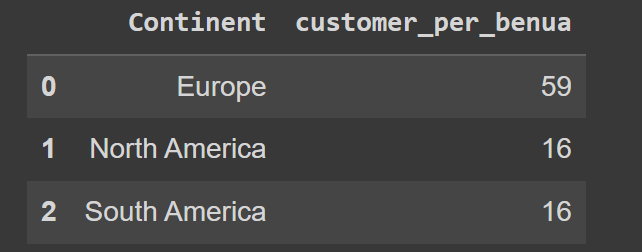

2. Dari tabel orderdetails kita bisa mengetahui total sales untuk setiap orderan yang masuk ke northwind dengan cara mengalikan jumlah barang terjual dan harga barangnya. Tampilkan total sales untuk order 10248, 10249, dan 11077, kemudian buat ranking dari total sales untuk setiap order id

In [ ]:
query = """

SELECT * FROM Orders
"""
pd.read_sql_query(query, db)

,OrderID,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2014-07-04 08:00:00.000,2014-08-01 00:00:00.000,2014-07-16 00:00:00.000,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,None,51100,France
1,10249,TOMSP,6,2014-07-05 04:00:00.000,2014-08-16 00:00:00.000,2014-07-10 00:00:00.000,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,None,44087,Germany
2,10250,HANAR,4,2014-07-08 15:00:00.000,2014-08-05 00:00:00.000,2014-07-12 00:00:00.000,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,RJ,05454-876,Brazil
3,10251,VICTE,3,2014-07-08 14:00:00.000,2014-08-05 00:00:00.000,2014-07-15 00:00:00.000,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,None,69004,France
4,10252,SUPRD,4,2014-07-09 01:00:00.000,2014-08-06 00:00:00.000,2014-07-11 00:00:00.000,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,None,B-6000,Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,11073,PERIC,2,2016-05-05 12:00:00.000,2016-06-02 00:00:00.000,None,2,24.95,Pericles Comidas clásicas,Calle Dr. Jorge Cash 321,México D.F.,None,05033,Mexico
826,11074,SIMOB,7,2016-05-06 01:00:00.000,2016-06-03 00:00:00.000,None,2,18.44,Simons bistro,Vinbæltet 34,Kobenhavn,None,1734,Denmark
827,11075,RICSU,8,2016-05-06 18:00:00.000,2016-06-03 00:00:00.000,None,2,6.19,Richter Supermarkt,Starenweg 5,Genève,None,1204,Switzerland
828,11076,BONAP,4,2016-05-06 00:00:00.000,2016-06-03 00:00:00.000,None,2,38.28,Bon app',"12, rue des Bouchers",Marseille,None,13008,France


In [ ]:
#MINI CASE NO 2
query = """

SELECT OrderID, ProductID, UnitPrice, Quantity, UnitPrice * Quantity as Sales,
RANK() OVER(PARTITION BY OrderID ORDER BY (UnitPrice * Quantity)) AS rank_sales
FROM OrderDetails
WHERE OrderID IN (10248, 10249, 11077)
"""
pd.read_sql_query(query, db)

,OrderID,ProductID,UnitPrice,Quantity,Sales,rank_sales
0,10248,42,9.80,10,98.00,1
1,10248,11,14.00,12,168.00,2
2,10248,72,34.80,5,174.00,3
3,10249,14,18.60,9,167.40,1
4,10249,51,42.40,40,1696.00,2
5,11077,52,7.00,2,14.00,1
6,11077,66,17.00,1,17.00,2
7,11077,23,9.00,2,18.00,3
8,11077,4,22.00,1,22.00,4
9,11077,14,23.25,1,23.25,5


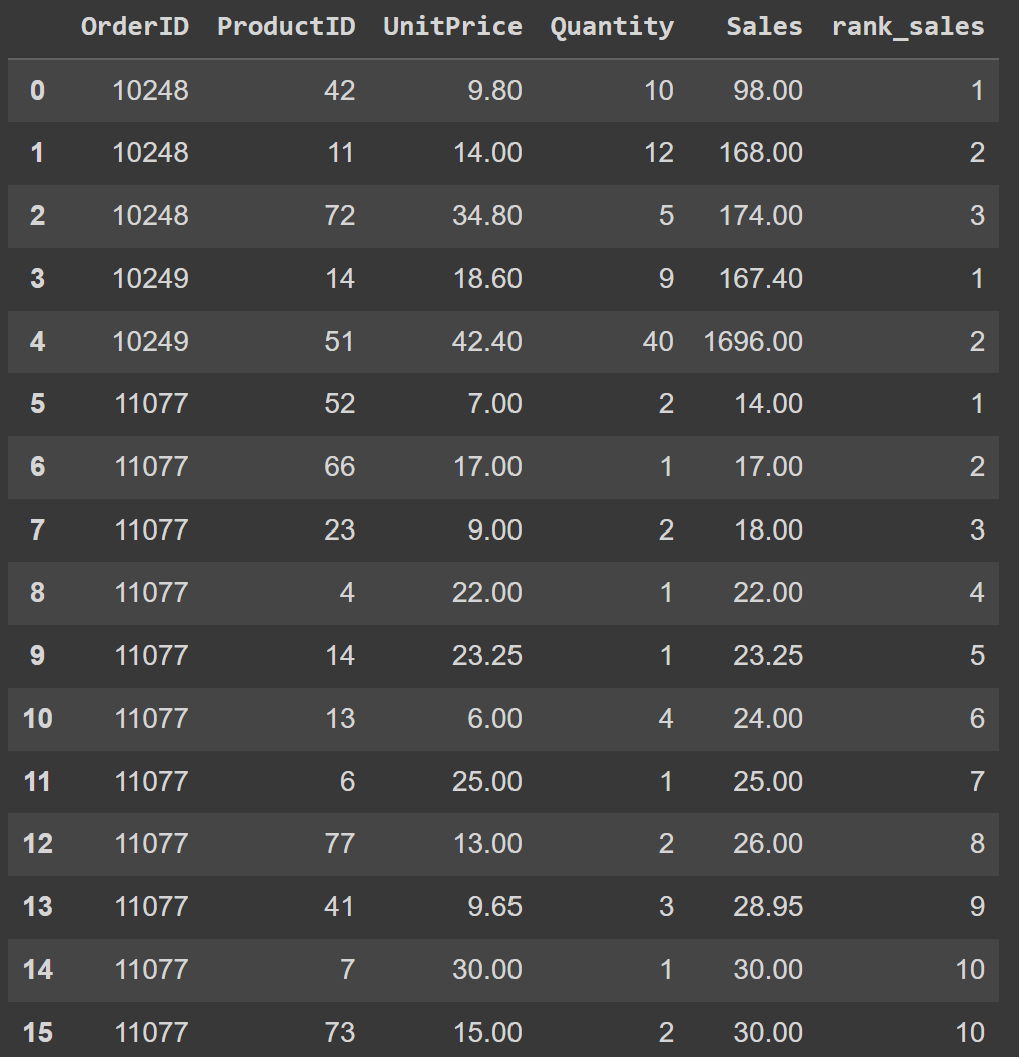

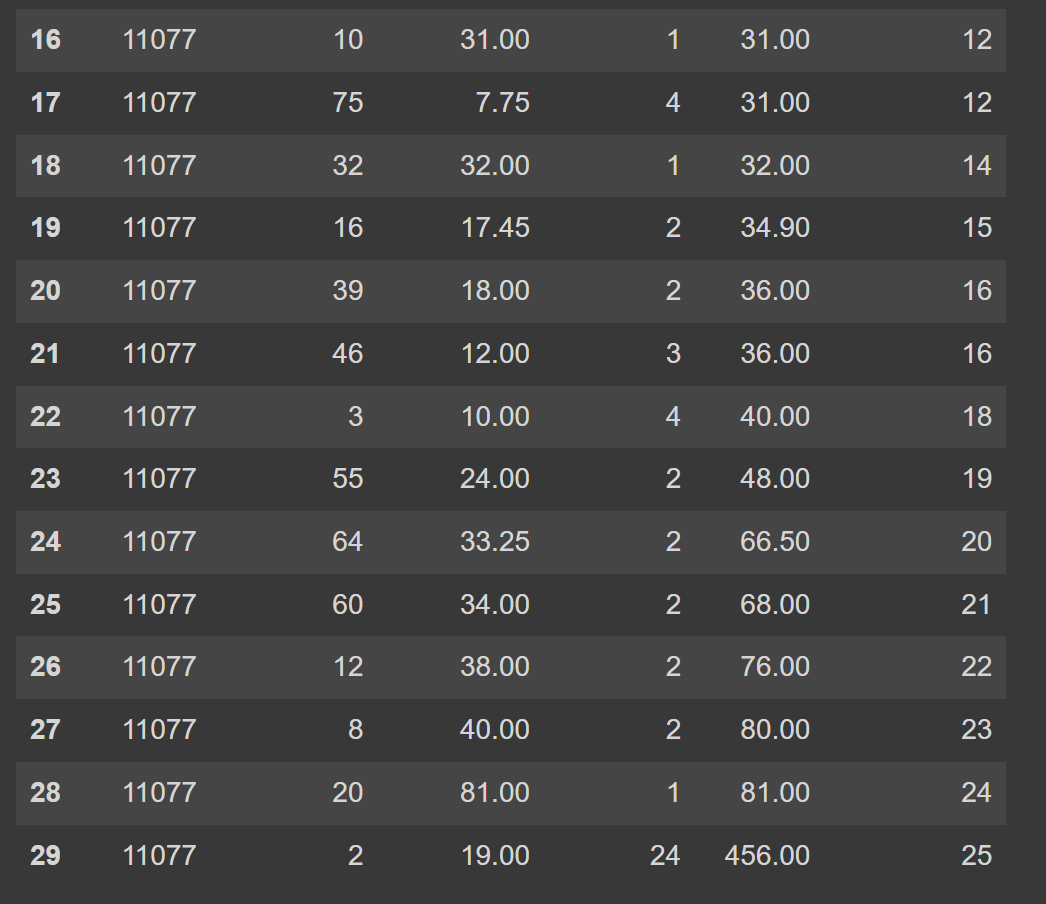

3. Buat query untuk melihat perbandingan antara Freight dari suatu customer dengan rata-rata Freight untuk negara tujuan customer tersebut dari tabel orders. Hanya ambil data yang orderDate nya dilakukan antara tahun 2014 dan 2015, serta berasal dari benua South America (Hint : lakukan filtering mengikuti pembagian benua seperti di soal nomor 1)

In [ ]:
# MINI CASE NO 3
query = """

SELECT CustomerID,
      DATE(OrderDate) as order_date,
      ShipCountry,
      Freight,
      AVG(Freight) OVER(PARTITION BY ShipCountry) AS avg_freight_country
      FROM Orders
      WHERE strftime('%Y', order_date) BETWEEN '2014' AND '2015'
      AND ShipCountry IN ('Argentina', 'Brazil', 'Venezuela')
      ORDER BY avg_freight_country ASC
"""
pd.read_sql_query(query, db)

,CustomerID,order_date,ShipCountry,Freight,avg_freight_country
0,OCEAN,2015-01-09,Argentina,29.83,19.610000
1,RANCH,2015-02-17,Argentina,38.82,19.610000
2,CACTU,2015-04-29,Argentina,17.22,19.610000
3,OCEAN,2015-05-08,Argentina,8.12,19.610000
4,RANCH,2015-10-24,Argentina,22.57,19.610000
...,...,...,...,...,...
84,HILAA,2015-10-15,Venezuela,3.52,67.644643
85,LINOD,2015-11-04,Venezuela,141.06,67.644643
86,LILAS,2015-12-16,Venezuela,42.13,67.644643
87,GROSR,2015-12-18,Venezuela,1.51,67.644643


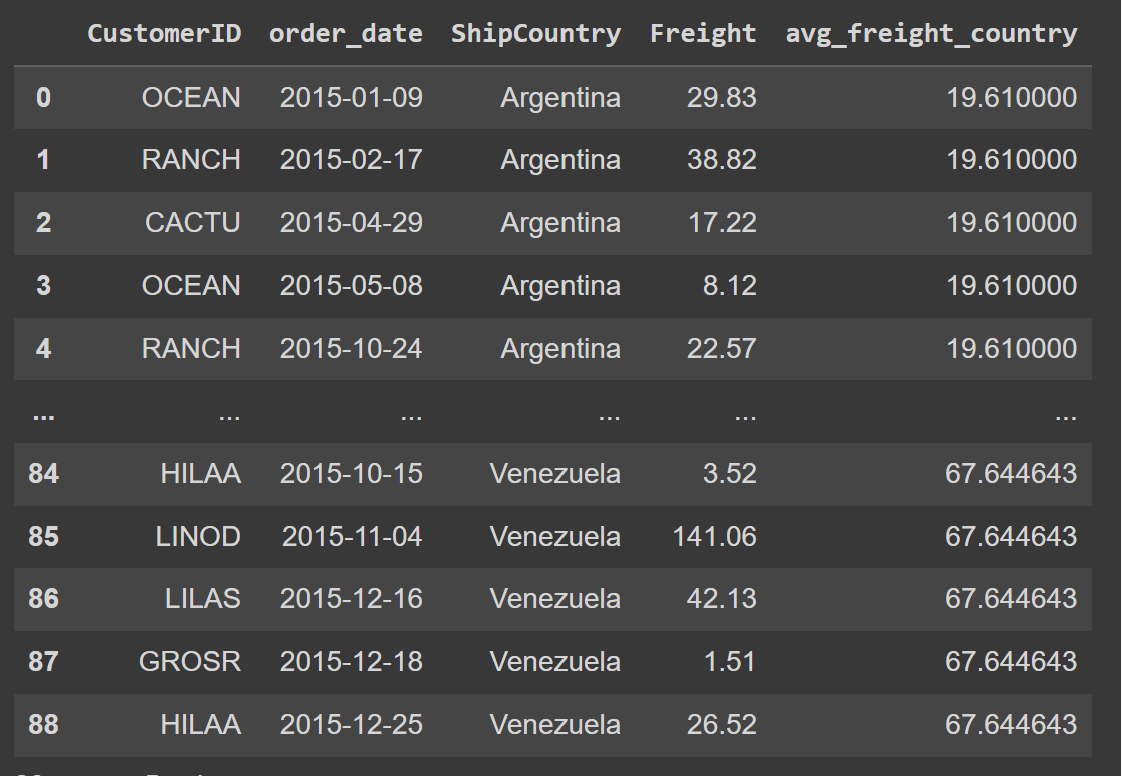

4. Dari tabel orders kita juga bisa melihat kapan deadline pengiriman barang berdasarkan kolom RequiredDate, serta kapan kita mengirim barang berdasarkan kolom ShippedDate. Buatlah pengelompokkan untuk melihat apakah pengiriman dilakukan sebelum deadline atau melewati deadline yang ditentukan. (Hint : hitung selisih antara RequiredDate dan ShippedDate. Jika selisihnya positif , maka kelompokkan menjadi 'pengiriman sebelum deadline'. Jika negatif, maka kelompokkan sebagai 'pengiriman telat!'). Ambil data dari tahun 2014 saja, dan pastikan kolom selisih waktu tidak bernilai null

In [ ]:
# MINI CASE NO 4
query = """

SELECT DATE(ShippedDate) as shipment_date, DATE(RequiredDate) as Required_date, julianday(DATE(ShippedDate)) - julianday(DATE(RequiredDate)) as DateDIff,
       CASE
       WHEN julianday(DATE(ShippedDate)) - julianday(DATE(RequiredDate)) < 0 THEN 'pengiriman telat!'
       WHEN julianday(DATE(ShippedDate)) - julianday(DATE(RequiredDate)) > 0 THEN 'pengiriman sebelum deadline'
       ELSE 'Nol' END AS Status_Shipment
       FROM Orders
       WHERE STRFTIME('%Y', shipment_date) BETWEEN '2014' AND '2015'
       AND STRFTIME('%Y', Required_date) BETWEEN '2014' AND '2015'
       AND shipment_date IS NOT NULL
       AND Required_date IS NOT NULL
       ORDER BY DateDIff  ASC LIMIT 152
"""
pd.read_sql_query(query, db)

,shipment_date,Required_date,DateDIff,Status_Shipment
0,2014-11-08,2014-12-17,-39.0,pengiriman telat!
1,2015-02-07,2015-03-18,-39.0,pengiriman telat!
2,2015-02-28,2015-04-08,-39.0,pengiriman telat!
3,2014-10-21,2014-11-28,-38.0,pengiriman telat!
4,2014-07-10,2014-08-16,-37.0,pengiriman telat!
...,...,...,...,...
147,2015-09-30,2015-10-24,-24.0,pengiriman telat!
148,2015-10-13,2015-11-06,-24.0,pengiriman telat!
149,2015-11-18,2015-12-12,-24.0,pengiriman telat!
150,2015-11-21,2015-12-15,-24.0,pengiriman telat!


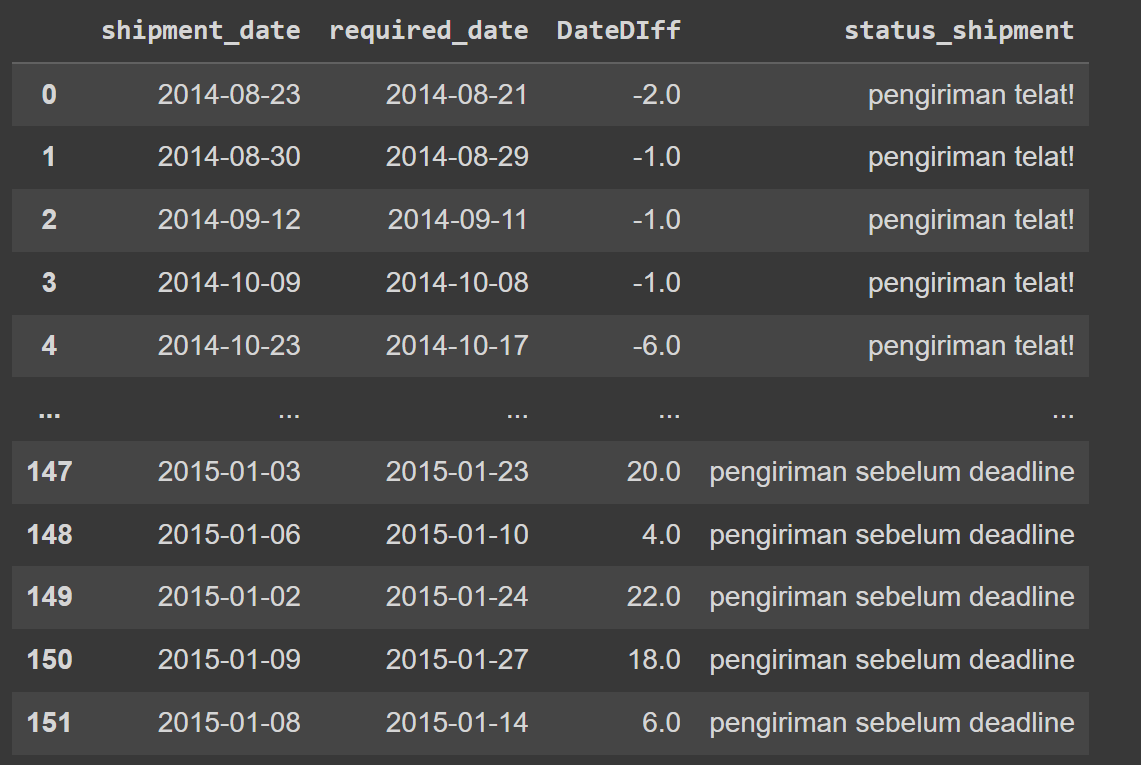